<a href="https://colab.research.google.com/github/Aurora-Fund-Analytics/forecast-model/blob/main/notebooks/test_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# =====================================
# 1. Install dependencies
# =====================================
!pip install yfinance ta torch scikit-learn matplotlib --quiet

# =====================================
# 2. Imports
# =====================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import ta
import os

In [51]:
# =====================================
# 3. Parameters
# =====================================
tickers = ['SPY','QQQ','IWM','EEM','TLT','GLD','XLK','XLF','XLE']  # Multi-ETF training
prediction_symbol = 'E1VFVN30'  # VN30 ETF
start_date = '2015-01-01'
end_date = '2025-08-27'
window_size = 60
batch_size = 64
epochs = 15
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [52]:
# =====================================
# 4. Download training data
# =====================================
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', progress=False)
print("Data downloaded for ETFs:", len(data))

# Flatten multi-index into one DataFrame
frames = []
for ticker in tickers:
    df = data[ticker].copy()
    df.columns = [col.lower() for col in df.columns]
    df['ticker'] = ticker
    frames.append(df.reset_index())
df_all = pd.concat(frames, ignore_index=True)

/tmp/ipython-input-3866571539.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', progress=False)


Data downloaded for ETFs: 2678


In [53]:
# =====================================
# 5. Feature Engineering
# =====================================
def add_features(df):
    df['return'] = df['close'].pct_change()
    df['volatility'] = df['return'].rolling(10).std()
    df['ma_10'] = df['close'].rolling(10).mean()
    df['ma_20'] = df['close'].rolling(20).mean()
    # RSI
    df['rsi_14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_hist'] = macd.macd_diff()
    return df

df_all = df_all.groupby('ticker', group_keys=False).apply(add_features)
df_all.dropna(inplace=True)

feature_cols = ['close','volume','return','volatility','ma_10','ma_20','rsi_14','macd','macd_signal','macd_hist']
target_col = 'close'

/tmp/ipython-input-2180001656.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all = df_all.groupby('ticker', group_keys=False).apply(add_features)


In [54]:
# =====================================
# 6. Prepare sequences for LSTM
# =====================================
scaler = MinMaxScaler()
scaled_data = []
for ticker in tickers:
    df_t = df_all[df_all['ticker']==ticker]
    X = df_t[feature_cols].values
    X_scaled = scaler.fit_transform(X)
    for i in range(len(X_scaled)-window_size):
        scaled_data.append((X_scaled[i:i+window_size], X_scaled[i+window_size,0])) # predict close price
scaled_data = np.array(scaled_data, dtype=object)
print("Sequences prepared:", len(scaled_data))

# Train/val/test split
train_size = int(0.8 * len(scaled_data))
val_size = int(0.1 * len(scaled_data))
test_size = len(scaled_data) - train_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size+val_size]
test_data = scaled_data[train_size+val_size:]

class StockDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_loader = DataLoader(StockDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(StockDataset(val_data), batch_size=batch_size)
test_loader = DataLoader(StockDataset(test_data), batch_size=batch_size)

Sequences prepared: 23265


In [55]:
# =====================================
# 7. Define LSTM Model
# =====================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.head(out)

input_size = len(feature_cols)
model = LSTMRegressor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [56]:
# =====================================
# 8. Training loop
# =====================================
best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*x_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output.squeeze(), y_batch)
            val_loss += loss.item()*x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.6f} Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'lstm_stock_model.pt')


Epoch [1/15] Train Loss: 0.009486 Val Loss: 0.000368
Epoch [2/15] Train Loss: 0.000620 Val Loss: 0.000413
Epoch [3/15] Train Loss: 0.000514 Val Loss: 0.000238
Epoch [4/15] Train Loss: 0.000476 Val Loss: 0.000475
Epoch [5/15] Train Loss: 0.000418 Val Loss: 0.000209
Epoch [6/15] Train Loss: 0.000389 Val Loss: 0.000202
Epoch [7/15] Train Loss: 0.000344 Val Loss: 0.000281
Epoch [8/15] Train Loss: 0.000339 Val Loss: 0.000414
Epoch [9/15] Train Loss: 0.000310 Val Loss: 0.000162
Epoch [10/15] Train Loss: 0.000309 Val Loss: 0.000200
Epoch [11/15] Train Loss: 0.000286 Val Loss: 0.000172
Epoch [12/15] Train Loss: 0.000291 Val Loss: 0.000166
Epoch [13/15] Train Loss: 0.000283 Val Loss: 0.000302
Epoch [14/15] Train Loss: 0.000256 Val Loss: 0.000142
Epoch [15/15] Train Loss: 0.000252 Val Loss: 0.000134


In [65]:
df_pred = yf.download(prediction_symbol+'.VN', start='2024-01-01', end=end_date, progress=False)

/tmp/ipython-input-2505024000.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_pred = yf.download(prediction_symbol+'.VN', start='2024-01-01', end=end_date, progress=False)


In [71]:
df_pred.columns = [col[0].lower() for col in df_pred.columns.values]

Predicted next 7 closes: [32176.4722538  30228.16167355 28722.06224918 27460.76989651
 26390.94136357 25476.14494205 24691.67121291]


/tmp/ipython-input-3748342278.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_pred = yf.download(prediction_symbol+'.VN', start='2024-01-01', end=end_date, progress=False)


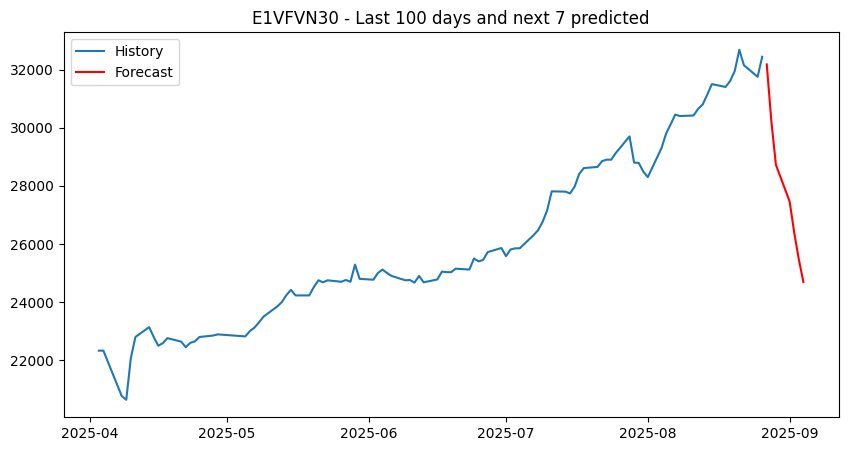

In [73]:
# =====================================
# 9. Predict for E1VFVN30 next 7 days
# =====================================
df_pred = yf.download(prediction_symbol+'.VN', start='2024-01-01', end=end_date, progress=False)
df_pred.columns = [col[0].lower() for col in df_pred.columns.values]
df_pred = add_features(df_pred)
df_pred.dropna(inplace=True)

# Use last window for prediction
X_full = df_pred[feature_cols].values
X_scaled = scaler.fit_transform(X_full)

last_seq = torch.tensor(X_scaled[-window_size:], dtype=torch.float32).unsqueeze(0).to(device)
model.load_state_dict(torch.load('lstm_stock_model.pt'))
model.eval()

future_preds = []
for _ in range(7):
    with torch.no_grad():
        pred = model(last_seq).item()
    future_preds.append(pred)
    # append predicted close and zeros for other features (simple iterative)
    next_row = np.zeros((len(feature_cols),))
    next_row[0] = pred
    new_seq = torch.cat([last_seq[:,1:,:], torch.tensor(next_row, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)], dim=1)
    last_seq = new_seq

# Inverse scale predictions
dummy = np.zeros((len(future_preds), len(feature_cols)))
dummy[:,0] = future_preds
future_prices = scaler.inverse_transform(dummy)[:,0]

print("Predicted next 7 closes:", future_prices)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_pred.index[-100:], df_pred['close'].values[-100:], label="History")
plt.plot(pd.date_range(df_pred.index[-1], periods=8, freq='B')[1:], future_prices, label="Forecast", color='red')
plt.title(f"{prediction_symbol} - Last 100 days and next 7 predicted")
plt.legend()
plt.show()